In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

In [6]:
eta = 0.3
N_stars = 100000
mean_FeH = -0.03   # Mean metallicity [Fe/H]
std_FeH = 0.2      # Standard deviation of metallicity [Fe/H]
FeH = np.random.normal(mean_FeH, std_FeH, N_stars)


In [1]:
# Constants
N_stars = 100000  # Total number of mock stars
mean_FeH = -0.03   # Mean metallicity [Fe/H]
std_FeH = 0.2      # Standard deviation of metallicity [Fe/H]
eta = 0.3          # Overall planet occurrence rate
M_sun = 1.0        # Solar mass in solar masses
R_sun_AU = 0.00465047  # Solar radius in astronomical units (AU)
p_value_threshold = 0.026  # Observed p-value threshold
num_samples = 200  # Number of random samples
fraction_threshold = 0.95  # Fraction of samples below p-value threshold

In [4]:
# Generate mock stars with metallicity distribution
FeH = np.random.normal(mean_FeH, std_FeH, N_stars)  # [Fe/H] distribution

# Function to compute alpha given gamma and eta
def compute_alpha(gamma, eta, FeH):
    avg = np.mean(10 ** (gamma * FeH))
    alpha = eta / avg
    return alpha

# Function to compute the fraction of samples with p-value below threshold
def compute_fraction_pvalue_below_threshold(FeH_transiting, FeH_non_transiting, N_sample, num_samples, p_value_threshold):
    count = 0
    num_transiting = len(FeH_transiting)
    num_non_transiting = len(FeH_non_transiting)
    if num_transiting < N_sample or num_non_transiting < N_sample:
        return 0  # Not enough data
    for _ in range(num_samples):
        sample_transiting = np.random.choice(FeH_transiting, N_sample, replace=False)
        sample_non_transiting = np.random.choice(FeH_non_transiting, N_sample, replace=False)
        _, p_value = ks_2samp(sample_transiting, sample_non_transiting)
        if p_value < p_value_threshold:
            count += 1
    fraction = count / num_samples
    return fraction

# Range of gamma values to explore
gamma_values = np.arange(0.0, 1.1, 0.1)
N_sample_results = []

for gamma in gamma_values:
    # Step 1: Compute alpha
    alpha = compute_alpha(gamma, eta, FeH)
    
    # Step 2: Compute planet occurrence probability f(Z) for each star
    f_Z = alpha * 10 ** (gamma * FeH)
    f_Z = np.clip(f_Z, 0, 1)  # Ensure probabilities are between 0 and 1
    
    # Step 3: Assign planet-hosting status
    random_numbers = np.random.rand(N_stars)
    is_planet_host = random_numbers < f_Z
    host_indices = np.where(is_planet_host)[0]
    num_hosts = len(host_indices)
    
    # Step 4: Assign masses and radii to planet-hosting stars
    FeH_hosts = FeH[host_indices]
    M_star = M_sun * 10 ** (0.2 * FeH_hosts)  # Stellar masses
    R_star = R_sun_AU * (M_star / M_sun)      # Stellar radii in AU
    
    # Step 5: Assign orbital periods and compute semi-major axes
    num_hosts = len(host_indices)
    logP_min = np.log10(5)
    logP_max = np.log10(400)
    logP = np.random.uniform(logP_min, logP_max, num_hosts)
    P_days = 10 ** logP
    P_years = P_days / 365.25
    a = (P_years ** 2 * M_star) ** (1/3)  # Semi-major axis in AU
    
    # Step 6: Assign orbital inclinations and determine transiting planets
    cos_i = np.random.uniform(-1, 1, num_hosts)
    R_over_a = R_star / a
    is_transiting = cos_i < R_over_a
    transiting_indices = host_indices[is_transiting]
    non_transiting_indices = host_indices[~is_transiting]
    
    # Step 7: Add observational uncertainties to metallicity
    FeH_obs = FeH + np.random.normal(0, 0.09, N_stars)  # Using LAMOST error
    FeH_transiting = FeH_obs[transiting_indices]
    FeH_non_transiting = FeH_obs[non_transiting_indices]
    
    # Step 8: Determine N_sample where 95% of samples have p-value < 0.026
    N_sample_found = None
    N_sample_values = np.arange(100, 2001, 100)
    for N_sample in N_sample_values:
        fraction_below = compute_fraction_pvalue_below_threshold(
            FeH_transiting, FeH_non_transiting, N_sample, num_samples, p_value_threshold)
        if fraction_below >= fraction_threshold:
            N_sample_found = N_sample
            print(f"Gamma = {gamma:.2f}, N_sample = {N_sample}, Fraction = {fraction_below:.2f}")
            break
    N_sample_results.append(N_sample_found)

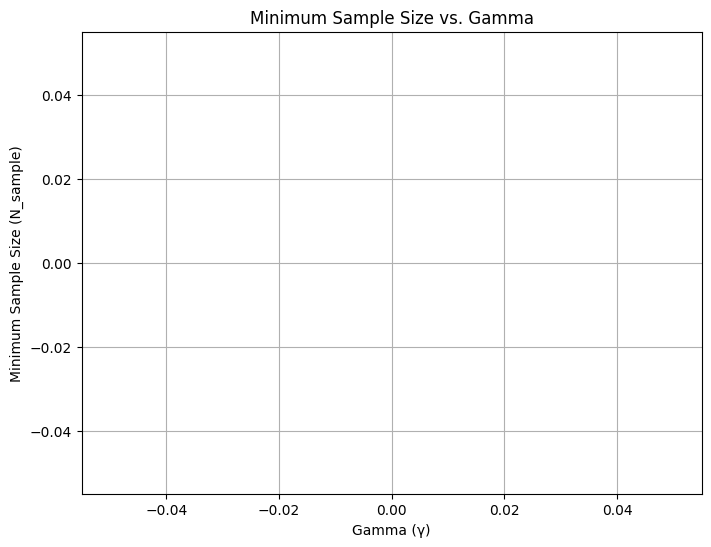

In [5]:
# Plotting the results
plt.figure(figsize=(8, 6))
plt.plot(gamma_values, N_sample_results, marker='o')
plt.xlabel('Gamma (γ)')
plt.ylabel('Minimum Sample Size (N_sample)')
plt.title('Minimum Sample Size vs. Gamma')
plt.grid(True)
plt.show()